# Start from here

In [1]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from visualization.metric import plot_performance

import xarray as xr
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
from qids_lib import QIDS

qids = QIDS(path_prefix='../../')

In [4]:
base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
ds_bak = base_ds.merge(market_brief_ds)
ds = ds_bak.copy()

## Some basic information about the dataset

In [7]:
ds

<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/22)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    mean_volume        (day, asset) float64 ...
    close_0            (day, asset) float64 ...
    open_0             (day, asset) float64 ...
    high_0             (day, asset) float64 ...
    low_0              (day, asset) float64 ...
    return_0           (day, asset) float64 ...

## Turnover

<AxesSubplot: xlabel='asset', ylabel='turnoverRatio'>

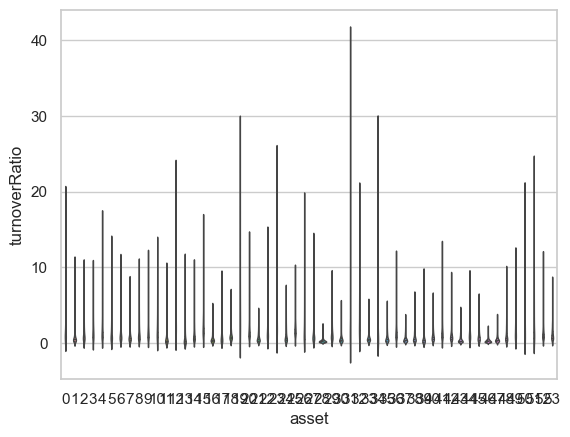

In [8]:
feature = 'turnoverRatio'
sns.violinplot(data=ds[feature].to_dataframe().reset_index(), x='asset', y=feature, inner='quart', linewidth=1)

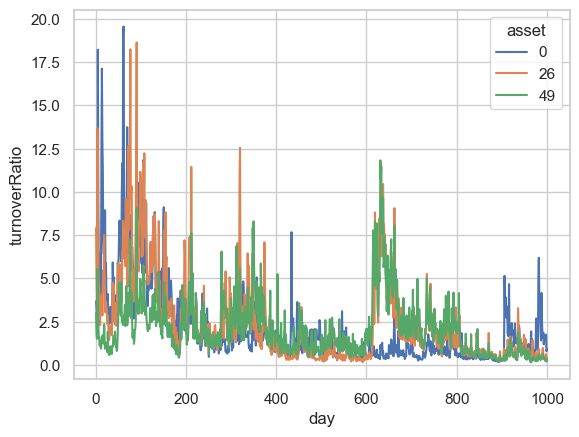

In [9]:
feature = 'turnoverRatio'
ds[feature].sel(asset=[0,26,49]).plot.line(x='day')

**For Turnover**

So apparently, the first 200 days display a quite different characteristic than the remaining days; the last 50 days is also worth noticing.

Also, the 26 and 49 asset has very similar turnoverRatios

<AxesSubplot: xlabel='turnoverRatio', ylabel='return_0'>

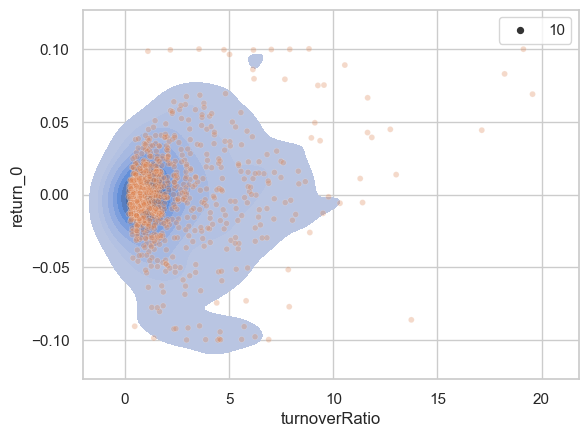

In [10]:
df = ds[['turnoverRatio', 'return_0']].sel(asset=0).to_dataframe()
plt.figure()
sns.kdeplot(data=df, x=feature, y='return_0', ax=plt.gca(), fill=True)
sns.scatterplot(data=df, x=feature, y='return_0', ax=plt.gca(), alpha=0.3, size=10)

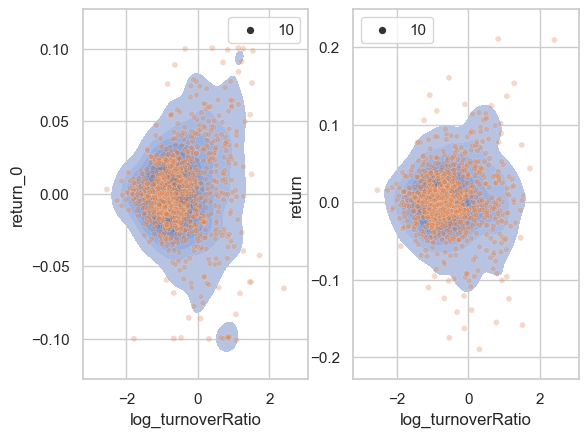

In [11]:
df = ds[['turnoverRatio', 'return_0', 'return']].sel(asset=1).to_dataframe()
df[f'log_{feature}'] = np.log(df[feature])
fig, axs = plt.subplots(nrows=1, ncols=2)
# return_label = 'return_0'
return_label = 'return'
for ax, return_label in zip(axs, ['return_0', 'return']):
    sns.kdeplot(data=df, x=f'log_{feature}', y=return_label, ax=ax, fill=True)
    sns.scatterplot(data=df, x=f'log_{feature}', y=return_label, ax=ax, alpha=0.3, size=10)

Question: Does the turnoverRatio correlate across different assets?

In [12]:
corr = ds.sel(day=slice(200,998))['turnoverRatio'].to_dataframe().reset_index().pivot(index='day', columns='asset', values='turnoverRatio').corr()
corr.index.rename('asset_0', inplace=True)
corr_long = corr.stack().rename('correlation')

Text(0.5, 1.0, 'Correlation plot for turnoverRatio')

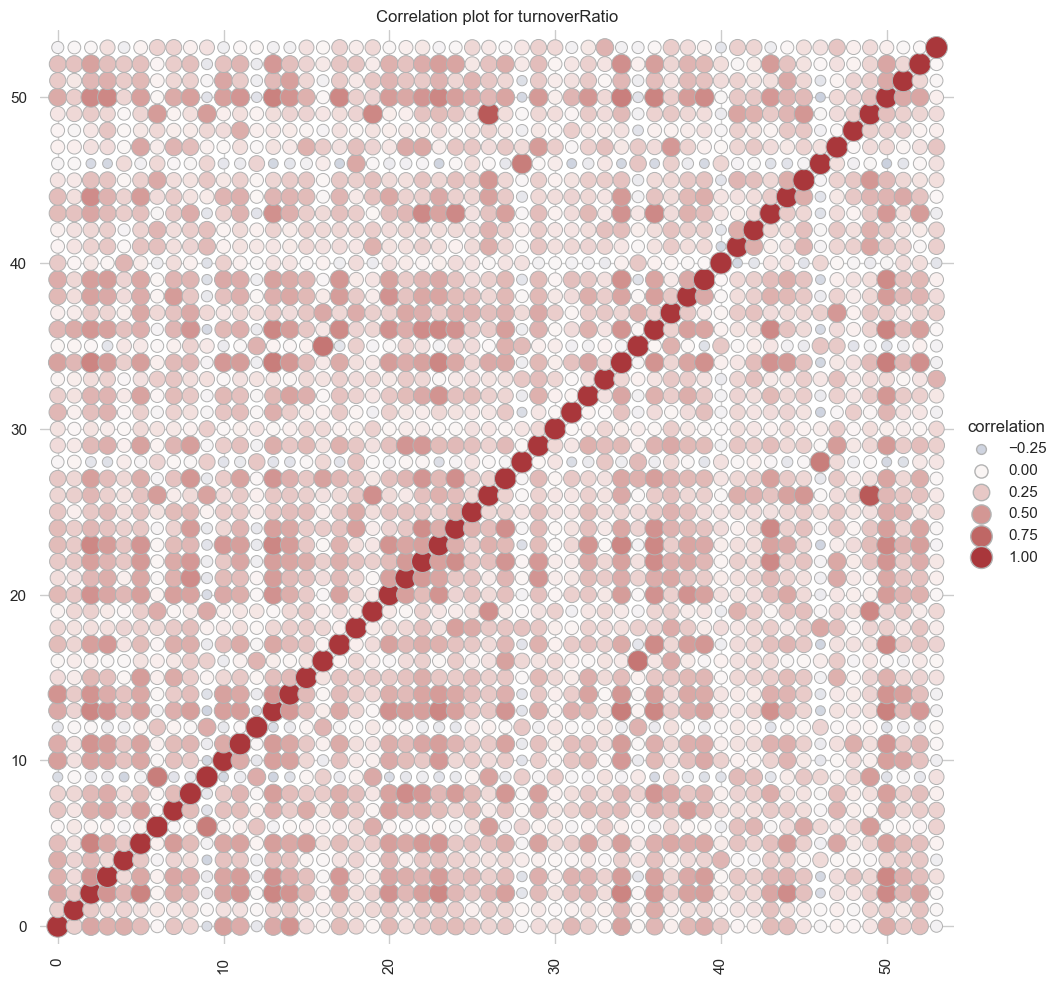

In [13]:
g = sns.relplot(
    data=corr_long.reset_index(),
    x='asset', y='asset_0', hue='correlation', size='correlation',
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
plt.title(f'Correlation plot for {feature}')

## TransactionAmount

<AxesSubplot: xlabel='asset', ylabel='transactionAmount'>

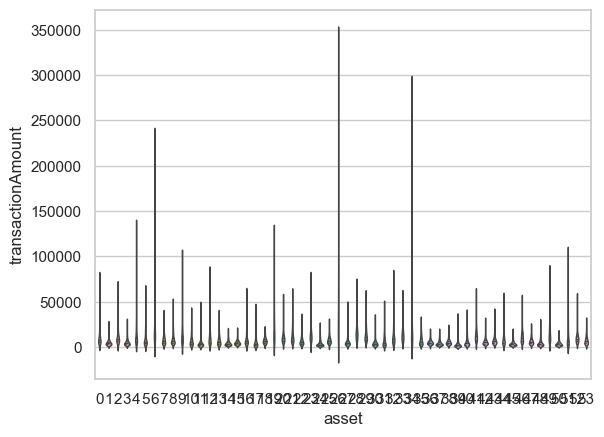

In [14]:
feature = 'transactionAmount'
sns.violinplot(data=ds[feature].to_dataframe().reset_index(), x='asset', y=feature, inner='quart', linewidth=1)

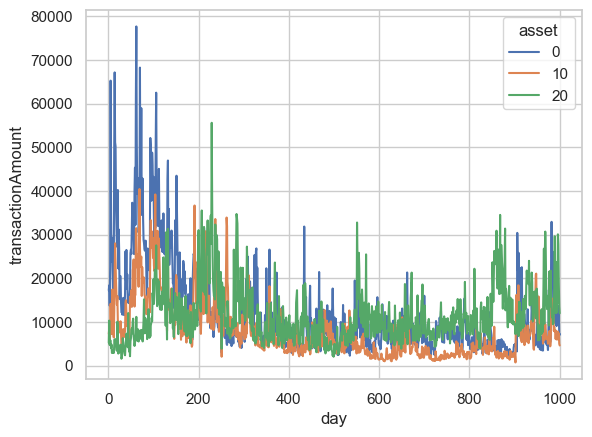

In [15]:
feature = 'transactionAmount'
ds[feature].sel(asset=[0,10,20]).plot.line(x='day')

Looks like TransactionAmount is very close to turnoverRatio, fishy

In [16]:
ds['market_share'] = ds['volume'].sum(dim='timeslot') / ds['turnoverRatio']

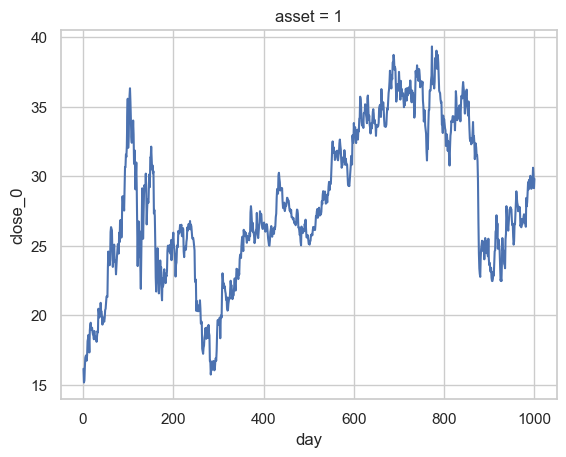

In [19]:
ds['close_0'].sel(asset=1).plot.line(x='day')

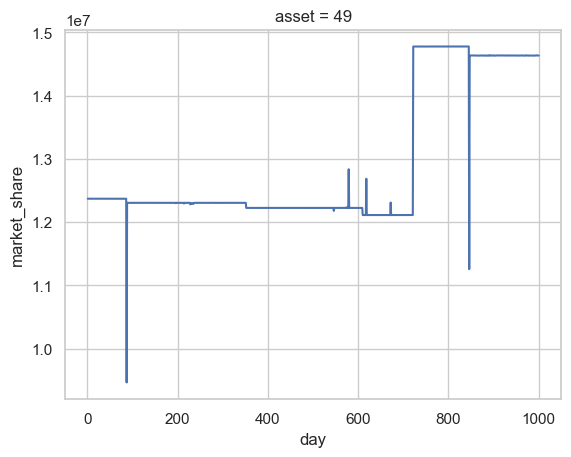

In [24]:
ds['market_share'].sel(asset=49).plot.line(x='day')

In [15]:
ratio = ds['transactionAmount'] / ds['turnoverRatio']

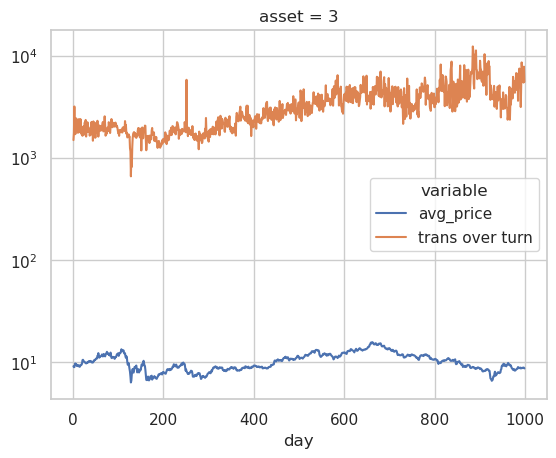

In [16]:
ds[['avg_price']].merge(ratio.rename('trans over turn')).sel(asset=3).to_array().plot.line(x='day')
plt.yscale('log')

Question: Does the transactionAmount correlate across different assets?

In [25]:
def plot_corr(ds, col):
    corr = ds[col].to_dataframe().reset_index().pivot(index='day', columns='asset', values=col).corr()
    corr.index.rename('asset_0', inplace=True)
    corr_long = corr.stack().rename('correlation')
    g = sns.relplot(
        data=corr_long.reset_index(),
        x='asset', y='asset_0', hue='correlation', size='correlation',
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 250), size_norm=(-.2, .8),
    )

    # Tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")
    plt.title(f'Correlation for {col}')

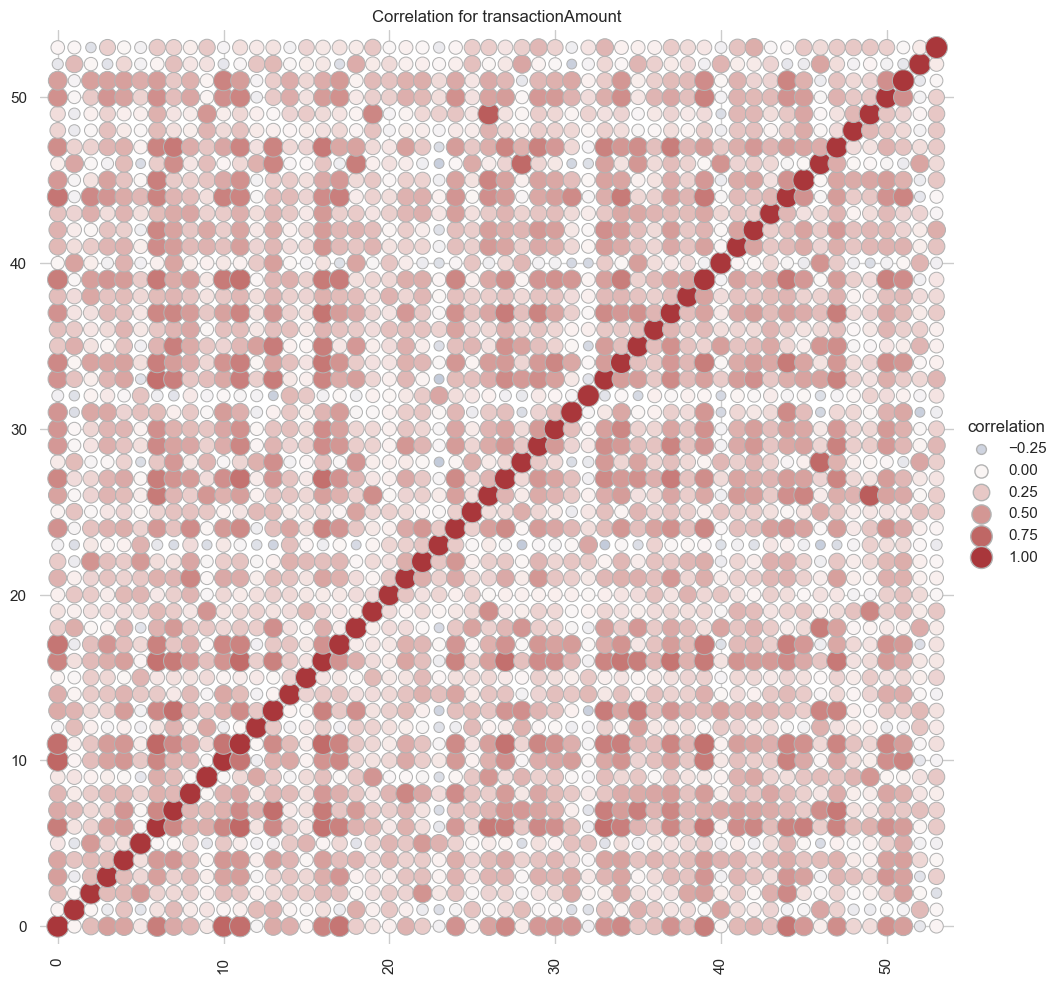

In [26]:
plot_corr(ds, 'transactionAmount')

How does transaction Amount correlate with return then?

It does not reveal much information either - but volatility seems to correlate with transaction

In [19]:
df = ds[['transactionAmount', 'return_0', 'return']].sel(asset=1).to_dataframe()
df[f'log_transactionAmount'] = np.log(df['transactionAmount'])
fig, axs = plt.subplots(nrows=1, ncols=2)
# return_label = 'return_0'
return_label = 'return'
for ax, return_label in zip(axs, ['return_0', 'return']):
    sns.kdeplot(data=df, x=f'log_transactionAmount', y=return_label, ax=ax, fill=True)
    sns.scatterplot(data=df, x=f'log_transactionAmount', y=return_label, ax=ax, alpha=0.3, size=10)

## PE and PE_TTM

In [27]:
sns.violinplot(data=ds['pe_ttm'].to_dataframe().reset_index(), x='asset', y='pe_ttm', inner='quart', linewidth=1)

<AxesSubplot: xlabel='asset', ylabel='pe_ttm'>

The asset=17 has very abnormal pe/pe_ttm, fishy

In [28]:
ds[['pe_ttm', 'pe']].sel(asset=17).to_array().plot.line(x='day')

That really scares me off. So what happens to the data? What is pe and pe_ttm?

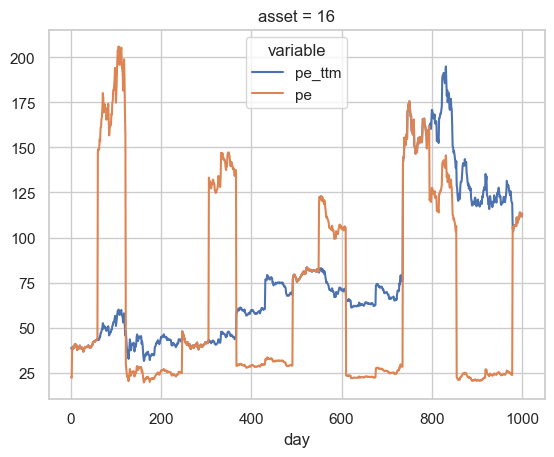

In [29]:
ds[['pe_ttm', 'pe']].sel(asset=16).to_array().plot.line(x='day')

okay, so if pe = price/earnings, then we should be able to revert earnings from price/pe

In [30]:
ds['earnings'] = ds['close'].sel(timeslot=50) / ds['pe']

In [31]:
ds['earnings']

<xarray.DataArray 'earnings' (day: 1000, asset: 54)>
array([[0.75489198, 0.59148743, 0.21538641, ..., 0.14429001, 0.18540647,
        0.59384701],
       [0.75508643, 0.59210588, 0.2155157 , ..., 0.14447083, 0.1851741 ,
        0.59379922],
       [1.01458397, 0.54462157, 0.2315508 , ..., 0.09306383, 0.16545369,
        0.42031796],
       ...,
       [0.19453525, 0.9136473 , 0.65012029, ..., 0.25453324, 0.99558502,
        0.9333133 ],
       [0.19449307, 0.91397735, 0.65006783, ..., 0.25455684, 0.99596597,
        0.932263  ],
       [0.19446805, 0.91378211, 0.65007048, ..., 0.25458359, 0.99573533,
        0.93305826]])
Coordinates:
  * day      (day) int32 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53

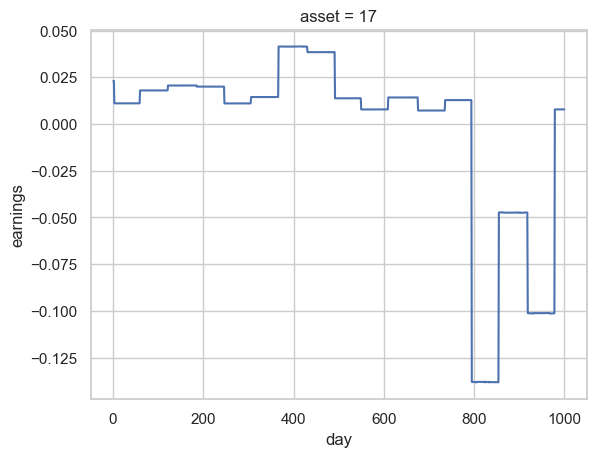

In [32]:
ds['earnings'].sel(asset=17).plot.line(x='day')

In [33]:
ds['earnings_ttm'] = ds['close'].sel(timeslot=50) / ds['pe_ttm']

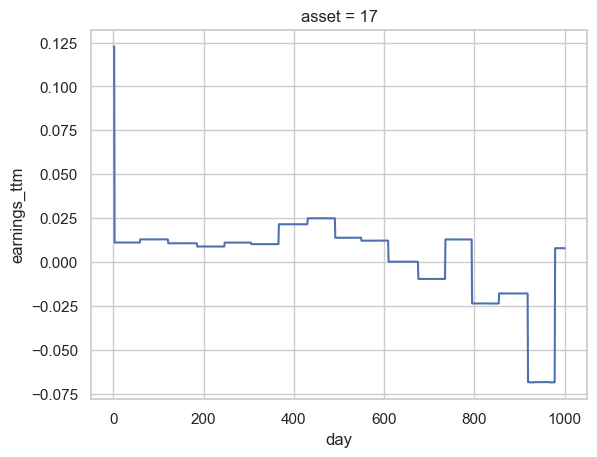

In [34]:
ds['earnings_ttm'].sel(asset=17).plot.line(x='day')

In [35]:
ds['my_earnings_ttm'] = ds['earnings'].rolling(day=240).mean()

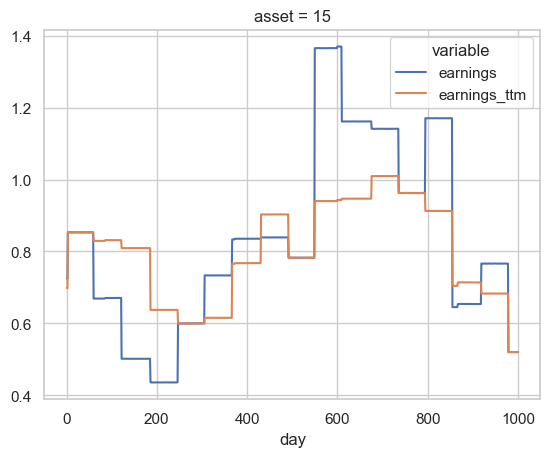

In [37]:
ds[['earnings', 'earnings_ttm']].sel(asset=15).to_array().plot.line(x='day')

TODO: how is earnings_ttm calculated? why there is always a segment that earnings and earnings_ttm agrees but not the remaining three?

ok, so does earnings provide a good hint of the return? let us overlay the close price with the earnings graph

In [16]:
ds['daily_close'] = ds['close'].sel(timeslot=50)

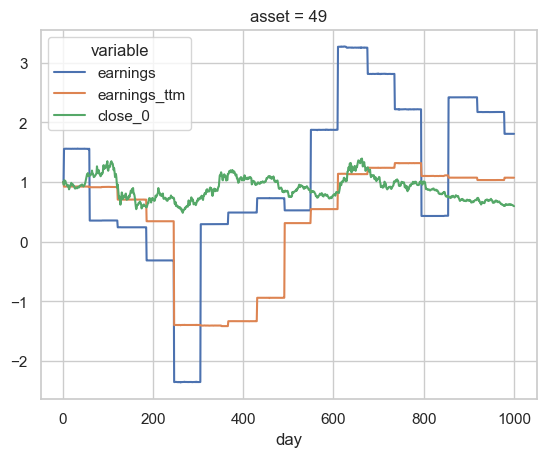

In [39]:
sub_ds = ds[['earnings', 'earnings_ttm', 'close_0']].sel(asset=49)
(sub_ds / sub_ds.sel(day=1)).to_array().plot.line(x='day')

In [18]:
__ds = ds.sel(asset=26)['earnings']

In [19]:
earnings_jump = (__ds - __ds.shift(day=1)).fillna(0)

In [20]:
ej = earnings_jump.where(np.abs(earnings_jump) > 1e-3, 0)

In [27]:
ej_1_exp = ej.rolling_exp(day=1, window_type='halflife').mean()

In [22]:
ej_5_exp = ej.rolling_exp(day=5, window_type='halflife').mean()

<xarray.DataArray ()>
array(-0.0007322)
Coordinates:
    asset    int64 26

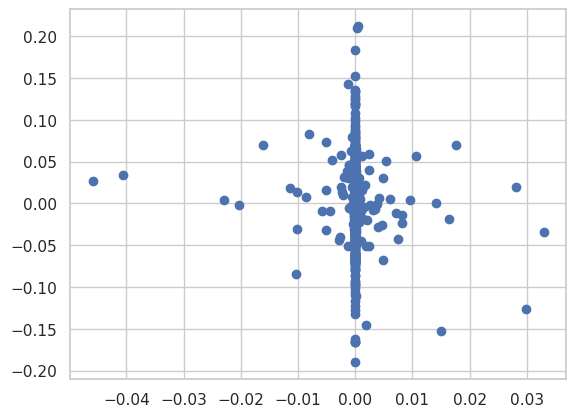

In [30]:
plt.scatter(ej_1_exp, ds.sel(asset=26)['return'])
xr.corr(ej_1_exp, ds.sel(asset=26)['return_0'])

In [25]:
from sklearn_xarray import wrap

class EarningsBasedModel:
    def __init__(self, exp_halflife = 20, per_eval_lookback = 60, pe_col = 'pe'):
        self.reg = LinearRegression()
        self.exp_halflife = exp_halflife
        self.per_eval_lookback = per_eval_lookback
        self.pe_col = pe_col
    
    def extract_ej(self, X):
        earnings = X[self.pe_col]
        earnings_jump = (earnings - earnings.shift(day=1)).fillna(0)
        ej_clean = earnings_jump.where(np.abs(earnings_jump) > 1e-3, 0)
        ej_exp = ej_clean.rolling_exp(day=exp_halflife).mean().isel(day=slice(self.per_eval_lookback-1,None))
        return ej_exp
    
    def fit_predict(self, X, y):
        ej_exp_df = self.extract_ej(X).to_dataset(name='ej_exp').to_dataframe()
        weight = np.abs(ej_exp_df.values[:, 0])
        # weight = 1
        # print(ej_exp_df)
        # print(y.to_series())
        self.reg.fit(ej_exp_df.values, y.to_series(), weight)
        pred = self.reg.predict(ej_exp_df.values)
        # print(self.reg.score(ej_exp_df.values, y.to_series()))
        return xr.DataArray.from_series(Series(pred, index=ej_exp_df.index))
    
    def predict(self, X):
        ej_exp_df = self.extract_ej(X).to_dataset(name='ej_exp').to_dataframe()
        pred = self.reg.predict(ej_exp_df.values)
        return xr.DataArray.from_series(Series(pred, index=ej_exp_df.index))

In [26]:
exp_halflife = 30
per_eval_lookback = 60
pe_col = 'pe_ttm'
model = EarningsBasedModel(exp_halflife = exp_halflife, per_eval_lookback = per_eval_lookback, pe_col = pe_col)
# ds[f'ej_ttm_{exp_day}_exp'] = ej_ttm_clean.rolling_exp(day=exp_day, window_type='halflife').mean()
feature = ['close_0', pe_col]
performance, cum_y_df = cross_validation(model, feature, 
                                         ds.sel(day=slice(200,998))[feature + ['return']],
                                         train_lookback=400, per_eval_lookback=per_eval_lookback)

  0%|          | 0/339 [00:00<?, ?it/s]

The ending score for metric train_r2 is: -9.3679e-05
The ending score for metric val_cum_r2 is: 4.6205e-04
The ending score for metric val_cum_pearson is: 2.8671e-02


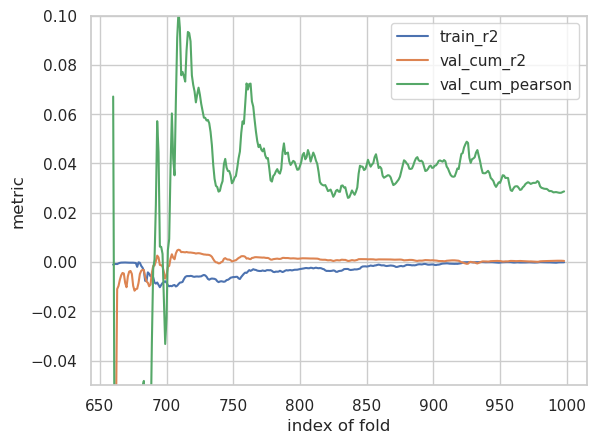

In [27]:
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

In [31]:
model = EarningsBasedModel(exp_halflife=60, per_eval_lookback=120, pe_col='pe_ttm')
performance = evaluation_for_submission(model, ds, qids, lookback_window=400, per_eval_lookback=model.per_eval_lookback)

  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: -4.2999e-03
The ending score for metric test_cum_r2 is: -4.2497e-03
The ending score for metric test_cum_pearson is: -3.3181e-03


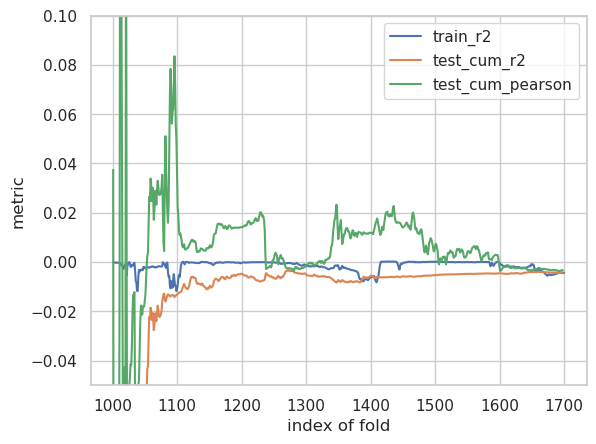

In [30]:
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])

anyways, that was some fun exercise

## PB

<AxesSubplot: xlabel='asset', ylabel='pb'>

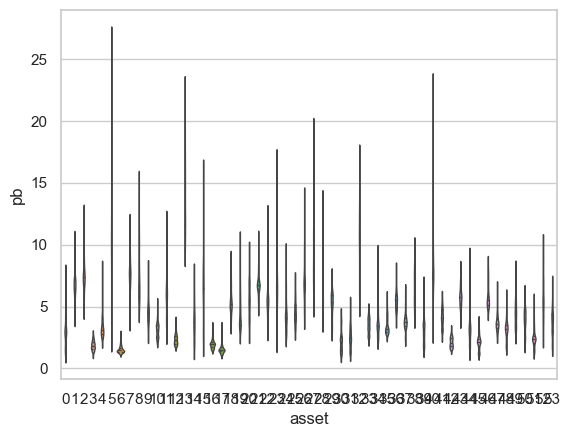

In [40]:
sns.violinplot(data=ds['pb'].to_dataframe().reset_index(), x='asset', y='pb', inner='quart', linewidth=1)

emmm, the pb value seems to vary a lot across assets

In [41]:
ds['book'] = ds['close_0'] / ds['pb']
ds['book_inc'] = ds['book'] / ds['book'].sel(day=1)

In [42]:
ds['earnings'] = ds['close_0'] / ds['pe']
ds['earnings_ttm'] = ds['close_0'] / ds['pe_ttm']

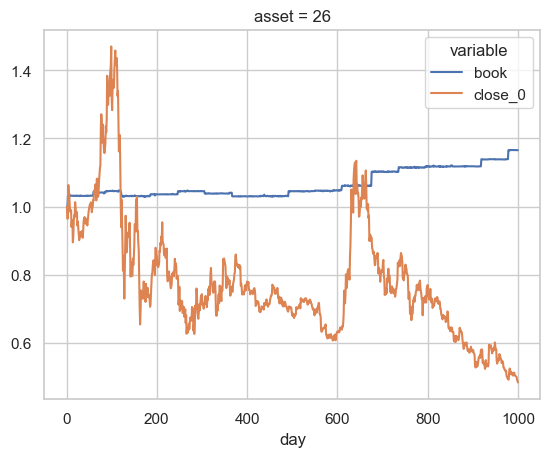

In [44]:
sub_ds = ds[['book', 'close_0']].sel(asset=26)
(sub_ds / sub_ds.sel(day=1)).to_array().plot.line(x='day')

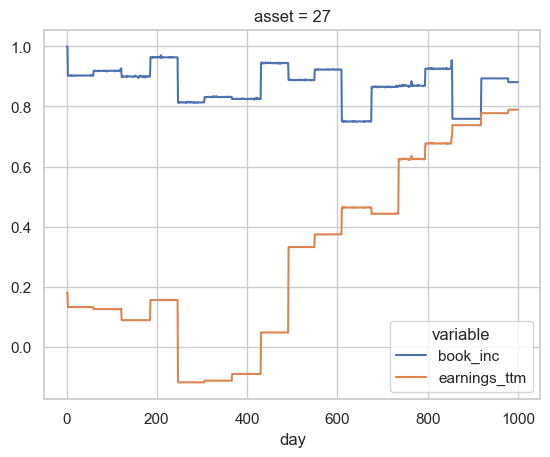

In [46]:
sub_ds = ds[['book_inc', 'earnings_ttm']].sel(asset=27)
sub_ds.to_array().plot.line(x='day')

conjecture: earnings is the derivative to book value

In [90]:
class BookBasedModel:
    def __init__(self, exp_halflife = 20, per_eval_lookback = 60):
        self.reg = LinearRegression()
        self.exp_halflife = exp_halflife
        self.per_eval_lookback = per_eval_lookback
    
    def extract_bj(self, X):
        book = X['close_0'] / X['pb']
        book_jump = book.diff('day', n=1)
        bj_clean = book_jump.where(np.abs(book_jump) > 1e-3, 0)
        relative_bj_clean = bj_clean / book
        ds = xr.Dataset({'bj_clean': bj_clean, 'relative_bj_clean': relative_bj_clean})
        # print('================')
        # print(ds)
        # print(ds.rolling_exp(day=exp_halflife).mean())
        # TODO: why day information is lost in rolling_exp?
        ds_exp = ds.rolling_exp(day=exp_halflife).mean().isel(day=slice(self.per_eval_lookback-2,None))
        return ds_exp
    
    def fit_predict(self, X, y):
        ds_exp_df = self.extract_bj(X).to_dataframe()
        weight = np.sqrt(np.abs(ds_exp_df.values[:, 0])+1e-3)
        # weight = 1
        # print(ej_exp_df)
        # print(y.to_series())
        self.reg.fit(ds_exp_df.values, y.to_series(), weight)
        pred = self.reg.predict(ds_exp_df.values)
        # print(self.reg.score(ej_exp_df.values, y.to_series()))
        return xr.DataArray.from_series(Series(pred, index=ds_exp_df.index))
    
    def predict(self, X):
        # print(X)
        ds_exp_df = self.extract_bj(X).to_dataframe()
        # print(ds_exp_df)
        pred = self.reg.predict(ds_exp_df.values)
        return xr.DataArray.from_series(Series(pred, index=ds_exp_df.index))

In [ ]:
exp_halflife = 10
per_eval_lookback = 60
model = BookBasedModel(exp_halflife = exp_halflife, per_eval_lookback = per_eval_lookback)
feature = ['close_0', 'pb']
performance, cum_y_df = cross_validation(model, feature, 
                                         ds.sel(day=slice(200,998))[feature + ['return']],
                                         train_lookback=300, per_eval_lookback=per_eval_lookback)

In [ ]:
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

In [91]:
model = BookBasedModel(exp_halflife = exp_halflife, per_eval_lookback = per_eval_lookback)
performance = evaluation_for_submission(model, ds_bak, qids, lookback_window=400, per_eval_lookback=model.per_eval_lookback)

  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: 2.5182e-04
The ending score for metric test_cum_r2 is: -2.4534e-03
The ending score for metric test_cum_pearson is: -4.4246e-03


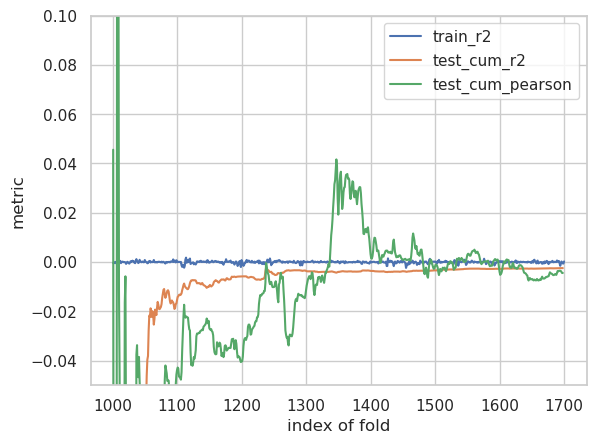

In [92]:
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])

nvm, not working again

can we cluster asset by their book value/earnings?

/tmp/ipykernel_149554/2636301194.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in g.legend.legendHandles:


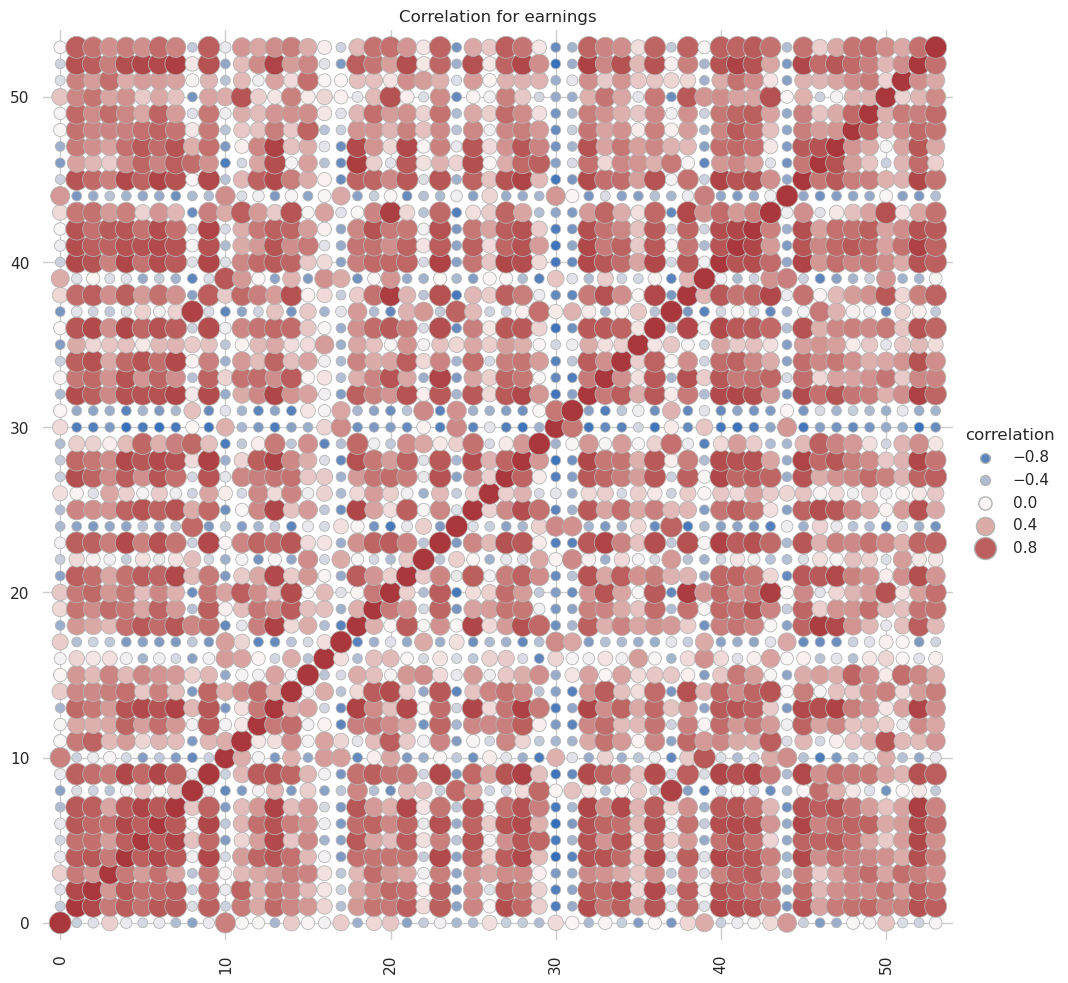

In [104]:
plot_corr(ds, 'earnings')

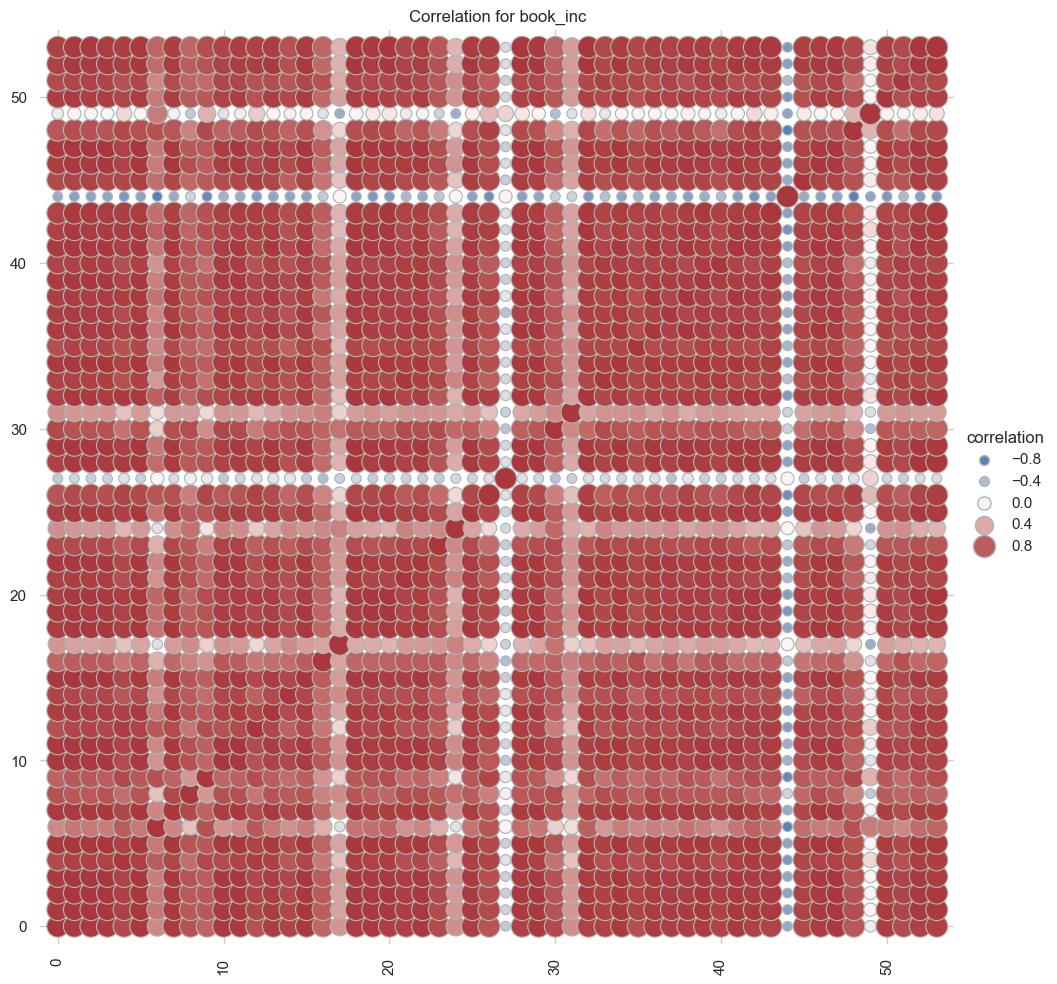

In [47]:
plot_corr(ds, 'book_inc')

hmm, interesting! so most assets have growing book values, while so "outliers" may exhibit different behaviors

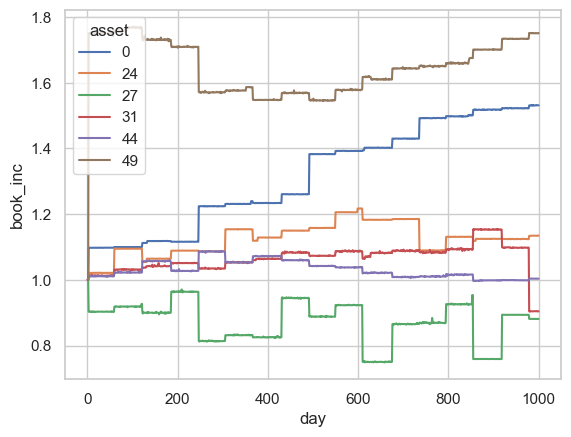

In [48]:
ds['book_inc'].sel(asset=[0, 24, 27, 31, 44, 49]).plot.line(x='day')

## PS

<AxesSubplot: xlabel='asset', ylabel='ps'>

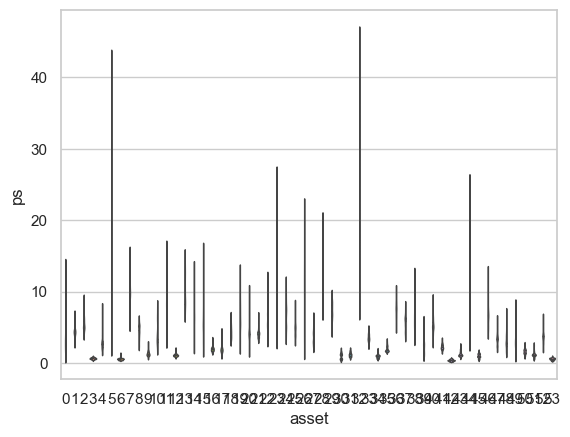

In [49]:
sns.violinplot(data=ds['ps'].to_dataframe().reset_index(), x='asset', y='ps', inner='quart', linewidth=1)

In [50]:
ds['sales'] = ds['close_0'] / ds['ps']
ds['sales_to_earnings'] = ds['sales'] / ds['earnings']
ds['sales_to_book'] = ds['sales'] / ds['book']

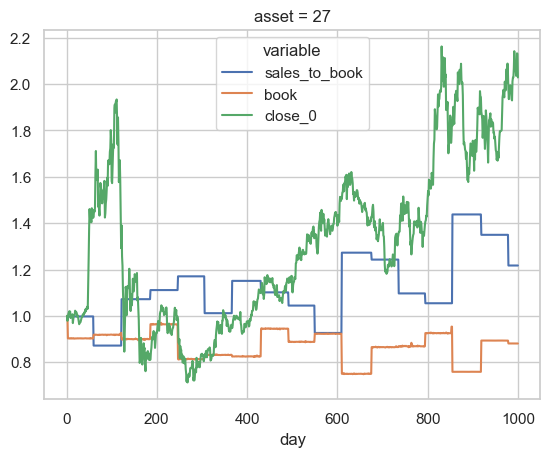

In [52]:
sub_ds = ds[['sales_to_book', 'book', 'close_0']].sel(asset=27)
(sub_ds / sub_ds.sel(day=1)).to_array().plot.line(x='day')

not much to say, but definitely sales correlates with earnings

## PCF

<AxesSubplot: xlabel='asset', ylabel='pcf'>

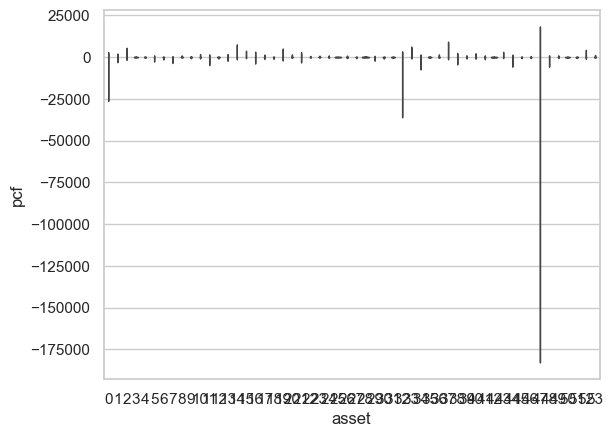

In [53]:
sns.violinplot(data=ds['pcf'].to_dataframe().reset_index(), x='asset', y='pcf', inner='quart', linewidth=1)

wow, very spicy!

In [54]:
ds['cf'] = ds['close_0'] / ds['pcf']

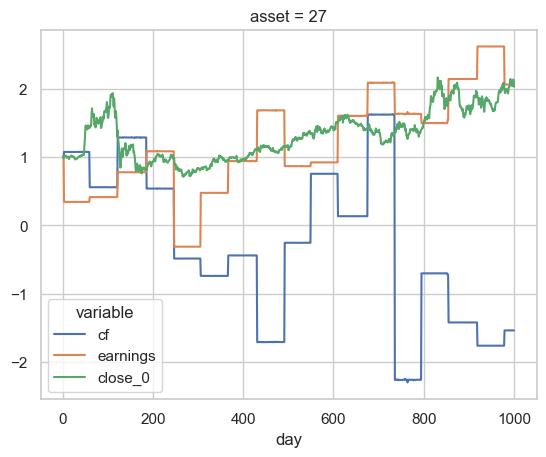

In [56]:
sub_ds = ds[['cf', 'earnings', 'close_0']].sel(asset=27)
(sub_ds / sub_ds.sel(day=1)).to_array().plot.line(x='day')

## End

In [64]:
ds['dividend'] = ds['cf'] + (ds['book'] - ds['book'].shift(day=60)) + ds['earnings']

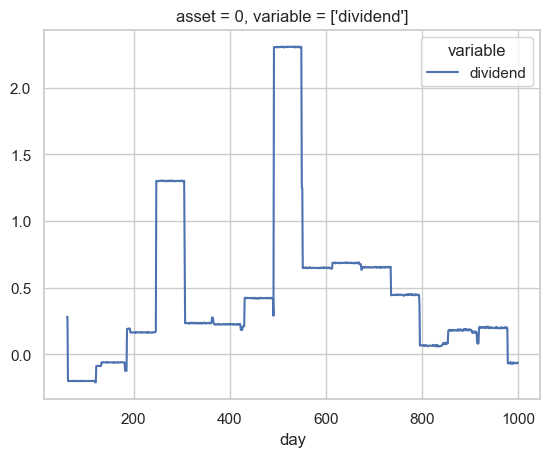

In [65]:
sub_ds = ds[['dividend']].sel(asset=0)
sub_ds.to_array().plot.line(x='day')